In [1]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import sys

sys.path.insert(0, '/nfs/privileged/isalazar/projects/ultrasound-image-formation/')
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from exploration.EMBC2024.cross_experiment.train import load_model as load_nair_model
from exploration.advtraining.ifsr001_nair_advTrain import load_model as load_nairAdv_model
from strohm_train import load_model as load_strohm_model
from wang_train import load_wang_model
from src.US_data import LoadData_phantomLIM_ATSmodel539, LoadDataPICMUS
from src.beamforming_utils import make_pixel_grid_from_pos
from utils import downsample_channel_data, compute_metrics
from src.beamforming_DAS import make_bimg_das1
from pytorch_msssim import MS_SSIM
from skimage.restoration import denoise_nl_means
import cv2

In [2]:
def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
this_dir = 'C:/Users/u_imagenes/PycharmProjects/ultrasound-image-formation/exploration/Journal2023/'
basic_dataset_dir = 'C:/Users/u_imagenes/PycharmProjects/ultrasound-image-formation/exploration/Journal2023/sample_data/'
h5_dataset_dir = f'{basic_dataset_dir}/verasonics'

In [5]:
# load model
epoch = 99
das_label = 'DAS'
# wang_label = 'wang_adv_eps0.008'
model_nair, _ = load_nair_model(model_dir=os.path.join(this_dir, "models", 'nair'),
                                epoch=epoch,
                                device=device)
model_strohm, _ = load_strohm_model(model_dir=os.path.join(this_dir, "models", 'strohm'),
                                    epoch=epoch,
                                    device=device)
model_wang, _, _, _, _ = load_wang_model(model_dir=os.path.join(this_dir, "models", 'wang'),
                                         epoch=epoch,
                                         num_downs=5,
                                         device=device)
model_nair.eval()
model_strohm.eval()
model_wang.eval()
print("")

Loading model 99...
Model 99 loaded.
Loading model 99...
Model 99 loaded.
Loading models 99...
Generator 99 loaded.
Discriminator 99 loaded.


In [6]:
# scipy.io.savemat('data_2_frame_65.mat', {'das_phantom': das_phantom})
# scipy.io.savemat('data_3_frame_64.mat', {'das_phantom': das_phantom})
# scipy.io.savemat('data_1_frame_36.mat', {'das_phantom': das_phantom})

In [7]:
def get_data_from_name(h5name):
    if h5name=='IS_L11-4v_data2_RF.h5':
        depths_ini_list = np.linspace(0, 80, 160)
        depth_ini = depths_ini_list[65]
        roi_ref = cv2.imread('data_2_frame_65.png', cv2.IMREAD_GRAYSCALE)

    elif h5name=='IS_L11-4v_data3_RF.h5':
        depths_ini_list = np.linspace(0, 80, 80)
        depth_ini = depths_ini_list[36]
        roi_ref = cv2.imread('data_3_frame_64.png', cv2.IMREAD_GRAYSCALE)

    elif h5name=='IS_L11-4v_data1_RF.h5':
        depths_ini_list = np.linspace(0, 80, 80)
        depth_ini = depths_ini_list[36]
        roi_ref = cv2.imread('data_1_frame_36.png', cv2.IMREAD_GRAYSCALE)
    else:
        raise NotImplementedError

    roi_ref = np.array(roi_ref)/255
    
    return depth_ini, roi_ref


In [8]:
for h5name in ['IS_L11-4v_data2_RF.h5', 'IS_L11-4v_data3_RF.h5', 'IS_L11-4v_data1_RF.h5']:
    depth_ini, roi_ref = get_data_from_name(h5name)
    
    P = LoadData_phantomLIM_ATSmodel539(h5_dir=h5_dataset_dir, h5_name=h5name)
    max_value = np.max(np.abs(np.array([P.idata, P.qdata])))
    P.idata = P.idata / max_value
    P.qdata = P.qdata / max_value
    
    laterals = np.linspace(P.phantom_xlims[0], P.phantom_xlims[-1], num=128)
    depths = np.linspace(depth_ini, depth_ini+50, num=800) / 1000
    P.grid_xlims = P.phantom_xlims
    P.grid_zlims = np.array([depth_ini, depth_ini+50]) / 1000
    # Downsample channel data
    channel_data_phantom = downsample_channel_data(copy.deepcopy(P),
                                                   laterals=laterals,
                                                   depths=depths,
                                                   device=device)
    channel_data_phantom = channel_data_phantom / channel_data_phantom.abs().max()
    laterals = np.linspace(P.grid_xlims[0], P.grid_xlims[-1], 128)
    grid_full = make_pixel_grid_from_pos(x_pos=laterals, z_pos=depths)
    
    das_phantom, _ = make_bimg_das1(copy.deepcopy(P), grid_full, device=device)
    nair_phantom = model_nair(channel_data_phantom)
    strohm_phantom = model_strohm(channel_data_phantom)
    N, C, H, W = channel_data_phantom.size()
    z = torch.randn(N, 1, H, W).to(device)
    wang_phantom = model_wang(torch.cat((channel_data_phantom, z), dim=1))
    
    output_in_bmode_format = lambda x: np.clip((x * 60 - 60).detach().cpu().numpy().squeeze(), a_min=-60, a_max=0)

    das_phantom  = np.clip(das_phantom, a_min=-60, a_max=0)
    nair_phantom = output_in_bmode_format(nair_phantom)
    strohm_phantom = output_in_bmode_format(strohm_phantom)
    wang_phantom = output_in_bmode_format(wang_phantom)
    bmodes = {'DAS': das_phantom, 'NAIR': nair_phantom, 'STROHM': strohm_phantom, 'WANG': wang_phantom}

    # # Plotting
    # extent_full = [P.grid_xlims[0] * 1e3, P.grid_xlims[-1] * 1e3,
    #            P.grid_zlims[-1] * 1e3, P.grid_zlims[0] * 1e3]
    # opts = {"extent": extent_full, "origin": "upper"}
    # ncols = len(bmodes)
    # fig, ax = plt.subplots(nrows=1, ncols=ncols+1, figsize=(3 * (ncols+1), 4))
    # for counter, name in enumerate(bmodes):
    #     ax[counter].imshow(bmodes[name], cmap="gray", vmin=-60, vmax=0, **opts)
    #     ax[counter].set_title(name)
    # ax[-1].imshow(roi_ref, cmap="gray", vmin=0, vmax=1, **opts)
    # plt.suptitle('%s' % h5name)

    # plt.imshow(roi_ref, cmap="gray", **opts)
    
    # Initialize lists to store parameters and iou values
    h_values = []
    patch_size_values = []
    patch_distance_values = []
    threshold_values = []
    name_values = []
    iou_values = []
    
    # Define parameter ranges
    h_range = np.linspace(0.01, 0.21, 11)
    patch_size_range = np.linspace(3, 15, 7)
    patch_distance_range = np.linspace(3, 21, 10)
    threshold_range = np.linspace(0.5, 0.65, 12)
    
    # Iterate over parameter combinations
    counter = 0
    for h in h_range:
        for patch_size in patch_size_range:
            for patch_distance in patch_distance_range:
                for threshold in threshold_range:
                    if counter % 600 == 0:
                        print(f"hsname: {h5name}, h: {h}, patch_size: {patch_size}, patch_distance: {patch_distance}, threshold: {threshold}")
                    counter = counter + 1

                    for name in bmodes:
                        bmode = bmodes[name]
                        bmode_img = (bmode + 60) / 60
                        smooth = denoise_nl_means(bmode_img,
                                                    h=h,
                                                    patch_size=int(patch_size),
                                                    patch_distance=int(patch_distance),
                                                    # sigma=sigma,
                                                    preserve_range=True)
                        roi_comp = smooth<threshold
                        iou = calculate_iou(roi_ref, roi_comp)
                        
                        # Append parameter values and iou to lists
                        h_values.append(h)
                        patch_size_values.append(patch_size)
                        patch_distance_values.append(patch_distance)
                        threshold_values.append(threshold)
                        name_values.append(name)
                        iou_values.append(iou)
    
    # Create DataFrame
    data = {
        'h': h_values,
        'patch_size': patch_size_values,
        'patch_distance': patch_distance_values,
        'threshold': threshold_values,
        'name': name_values,
        'iou': iou_values
    }
    
    df = pd.DataFrame(data)
    df.to_csv(f'{h5name[:-4]}.csv', index=False)  # Set index=False to exclude row numbers



Dataset successfully loaded
hsname: IS_L11-4v_data2_RF.h5, h: 0.01, patch_size: 3.0, patch_distance: 3.0, threshold: 0.5
hsname: IS_L11-4v_data2_RF.h5, h: 0.01, patch_size: 13.0, patch_distance: 3.0, threshold: 0.5
hsname: IS_L11-4v_data2_RF.h5, h: 0.03, patch_size: 9.0, patch_distance: 3.0, threshold: 0.5
hsname: IS_L11-4v_data2_RF.h5, h: 0.049999999999999996, patch_size: 5.0, patch_distance: 3.0, threshold: 0.5
hsname: IS_L11-4v_data2_RF.h5, h: 0.049999999999999996, patch_size: 15.0, patch_distance: 3.0, threshold: 0.5
hsname: IS_L11-4v_data2_RF.h5, h: 0.06999999999999999, patch_size: 11.0, patch_distance: 3.0, threshold: 0.5
hsname: IS_L11-4v_data2_RF.h5, h: 0.08999999999999998, patch_size: 7.0, patch_distance: 3.0, threshold: 0.5
hsname: IS_L11-4v_data2_RF.h5, h: 0.10999999999999997, patch_size: 3.0, patch_distance: 3.0, threshold: 0.5
hsname: IS_L11-4v_data2_RF.h5, h: 0.10999999999999997, patch_size: 13.0, patch_distance: 3.0, threshold: 0.5
hsname: IS_L11-4v_data2_RF.h5, h: 0.129

In [33]:
import scipy.io
# scipy.io.savemat('data_2_frame_65.mat', {'das_phantom': das_phantom})
# scipy.io.savemat('data_3_frame_64.mat', {'das_phantom': das_phantom})
# scipy.io.savemat('data_1_frame_36.mat', {'das_phantom': das_phantom})

In [12]:
extent_full = [P.grid_xlims[0] * 1e3, P.grid_xlims[-1] * 1e3,
           P.grid_zlims[-1] * 1e3, P.grid_zlims[0] * 1e3]

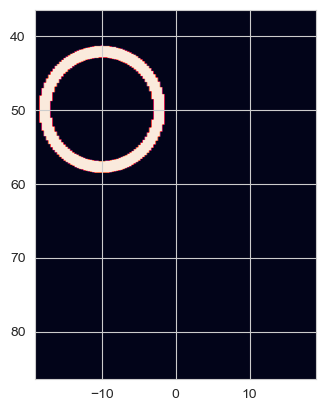

In [17]:
xctr, zctr = -10/1000, 50/1000
dist = np.sqrt((grid_full[:, :, 0] - xctr) ** 2 + (grid_full[:, :, 2] - zctr) ** 2)
r = 6/1000
r0 = r - 1/1000
r1 = r + 1/1000
r2 = np.sqrt(r0**2 + r1**2)
roi_i = dist <= r0
roi_o = (r1 <= dist) * (dist <= r2)

plt.imshow(roi_o*, extent=extent_full)

In [61]:
# Compute contrast ratio
def contrast(img1, img2):
    return 20 * np.log10(img1.mean() / img2.mean())
    # return 20 * np.log10(img1.median() / img2.median())


In [101]:
def get_contrast(bmodes, grid_full, h5name):
    if h5name == 'IS_L11-4v_data2_RF.h5':
        xctr, zctr = -8.5/1000, 17.5/1000
        dist = np.sqrt((grid_full[:, :, 0] - xctr) ** 2 + (grid_full[:, :, 2] - zctr) ** 2)
        r = 7/1000
        r0 = r - 2.0/1000
        r1 = r + 2.0/1000
        r2 = np.sqrt(r0**2 + r1**2)
        roi_i = dist <= r0
        roi_o = (r1 <= dist) * (dist <= r2)
        
        for bmf in bmodes:
            bmode = bmodes[bmf]
            env = 10**(bmode/20)
            env_in = env[roi_in]
            env_out = env[roi_out]
            contrast_value = contrast(env_in, env_out)
            print(f'{bmf}: {contrast_value}')
            
    if h5name == 'IS_L11-4v_data3_RF.h5':
        # xctr, zctr = -2.5/1000, 50.5/1000
        xctr, zctr = -20.0/1000, 50.5/1000
        dist = np.sqrt((grid_full[:, :, 0] - xctr) ** 2 + (grid_full[:, :, 2] - zctr) ** 2)
        r = 7/1000
        r0 = r - 2.0/1000
        r1 = r + 2.0/1000
        r2 = np.sqrt(r0**2 + r1**2)
        roi_i = dist <= r0
        roi_o = (r1 <= dist) * (dist <= r2)
        
        for bmf in bmodes:
            bmode = bmodes[bmf]
            env = 10**(bmode/20)
            env_in = env[roi_in]
            env_out = env[roi_out]
            contrast_value = contrast(env_in, env_out)
            print(f'{bmf}: {contrast_value}')
            
    if h5name == 'IS_L11-4v_data1_RF.h5':
        # xctr, zctr = -20.0/1000, 50.5/1000
        xctr, zctr = -0.0/1000, 50.5/1000
        # xctr, zctr = 17.5/1000, 50.5/1000
        dist = np.sqrt((grid_full[:, :, 0] - xctr) ** 2 + (grid_full[:, :, 2] - zctr) ** 2)
        r = 7/1000
        r0 = r - 2.0/1000
        r1 = r + 2.0/1000
        r2 = np.sqrt(r0**2 + r1**2)
        roi_i = dist <= r0
        roi_o = (r1 <= dist) * (dist <= r2)
        
        for bmf in bmodes:
            bmode = bmodes[bmf]
            env = 10**(bmode/20)
            env_in = env[roi_in]
            env_out = env[roi_out]
            contrast_value = contrast(env_in, env_out)
            print(f'{bmf}: {contrast_value}')

    return roi_i, roi_o

In [102]:
# for h5name in ['IS_L11-4v_data2_RF.h5', 'IS_L11-4v_data3_RF.h5', 'IS_L11-4v_data1_RF.h5']:
for h5name in ['IS_L11-4v_data1_RF.h5']:
    depth_ini, roi_ref = get_data_from_name(h5name)
    
    P = LoadData_phantomLIM_ATSmodel539(h5_dir=h5_dataset_dir, h5_name=h5name)
    max_value = np.max(np.abs(np.array([P.idata, P.qdata])))
    P.idata = P.idata / max_value
    P.qdata = P.qdata / max_value
    
    laterals = np.linspace(P.phantom_xlims[0], P.phantom_xlims[-1], num=128)
    depths = np.linspace(depth_ini, depth_ini+50, num=800) / 1000
    P.grid_xlims = P.phantom_xlims
    P.grid_zlims = np.array([depth_ini, depth_ini+50]) / 1000
    # Downsample channel data
    channel_data_phantom = downsample_channel_data(copy.deepcopy(P),
                                                   laterals=laterals,
                                                   depths=depths,
                                                   device=device)
    channel_data_phantom = channel_data_phantom / channel_data_phantom.abs().max()
    laterals = np.linspace(P.grid_xlims[0], P.grid_xlims[-1], 128)
    grid_full = make_pixel_grid_from_pos(x_pos=laterals, z_pos=depths)
    
    das_phantom, _ = make_bimg_das1(copy.deepcopy(P), grid_full, device=device)
    nair_phantom = model_nair(channel_data_phantom)
    strohm_phantom = model_strohm(channel_data_phantom)
    N, C, H, W = channel_data_phantom.size()
    z = torch.randn(N, 1, H, W).to(device)
    wang_phantom = model_wang(torch.cat((channel_data_phantom, z), dim=1))
    
    output_in_bmode_format = lambda x: np.clip((x * 60 - 60).detach().cpu().numpy().squeeze(), a_min=-60, a_max=0)

    das_phantom  = np.clip(das_phantom, a_min=-60, a_max=0)
    nair_phantom = output_in_bmode_format(nair_phantom)
    strohm_phantom = output_in_bmode_format(strohm_phantom)
    wang_phantom = output_in_bmode_format(wang_phantom)
    bmodes = {'DAS': das_phantom, 'NAIR': nair_phantom, 'STROHM': strohm_phantom, 'WANG': wang_phantom}
        
    roi_in, roi_out = get_contrast(bmodes, grid_full, h5name)
    
    

Dataset successfully loaded
DAS: -7.1845316886901855
NAIR: -5.2851879596710205
STROHM: -6.721676588058472
WANG: -5.682275295257568


Text(0.5, 0.98, 'IS_L11-4v_data1_RF.h5')

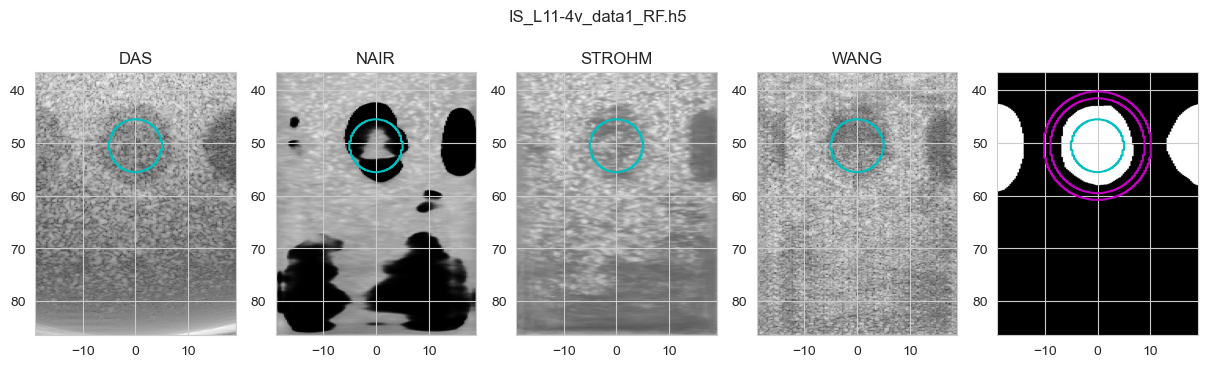

In [103]:
# Plotting
extent_full = [P.grid_xlims[0] * 1e3, P.grid_xlims[-1] * 1e3,
           P.grid_zlims[-1] * 1e3, P.grid_zlims[0] * 1e3]
opts = {"extent": extent_full, "origin": "upper"}
ncols = len(bmodes)
fig, ax = plt.subplots(nrows=1, ncols=ncols+1, figsize=(3 * (ncols+1), 4))
for counter, name in enumerate(bmodes):
    ax[counter].imshow(bmodes[name], cmap="gray", vmin=-60, vmax=0, **opts)
    # ax[counter].contourf(roi_in, )
    ax[counter].contour(roi_in, [0.5], colors="c", **opts)
    # ax[counter].contour(roi_out, [0.5], colors="m", **opts)
    ax[counter].set_title(name)
ax[-1].imshow(roi_ref, cmap="gray", vmin=0, vmax=1, **opts)
ax[-1].contour(roi_in, [0.5], colors="c", **opts)
ax[-1].contour(roi_out, [0.5], colors="m", **opts)
plt.suptitle('%s' % h5name)

In [37]:
import time

In [49]:
# ###############################
# # h, patch_size, patch_distance = 0.1, 5, 11  # for data2 frame 65
# h, patch_size, patch_distance = 0.05, 5, 11
# smooths = {}
# for counter, name in enumerate(bmodes):
#     bmode = bmodes[name]
#     bmode_img = (bmode + 60) / 60
#     # sigma = bmode_img.std()
#     # print(f"{sigma}")
#     bmode_nl = denoise_nl_means(bmode_img,
#                                 h=h,
#                                 patch_size=patch_size,
#                                 patch_distance=patch_distance,
#                                 # sigma=sigma,
#                                 preserve_range=True)
#     smooths[name] = bmode_nl

In [53]:
############    Segmentations     ###################
# threshold = 0.55  # for data2 frame 65
threshold = 0.6 # for data3 frame 64
# threshold = 0.5 # for data1 frame 36
segmentations = {}
for counter, name in enumerate(bmodes):
    print(f"{counter} - {name}")
    roi_comp = smooths[name]<threshold
    segmentations[name] = roi_comp
################################

0 - DAS
1 - NAIR
2 - STROHM
3 - WANG


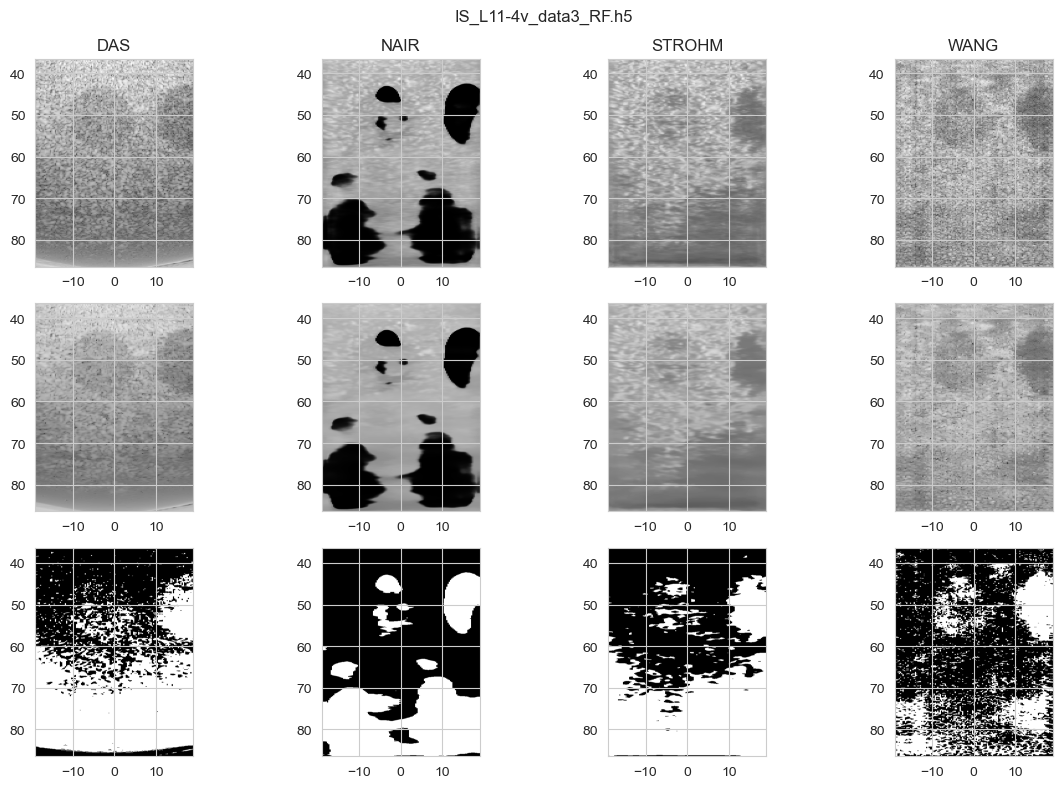

In [54]:
# ------ Plotting segmentations
nsegs = len(segmentations)
fig, ax = plt.subplots(nrows=3, ncols=nsegs, figsize=(3*nsegs, 8))
for counter, name in enumerate(segmentations):
    ax[0, counter].set_title(name)
    ax[0, counter].imshow(bmodes[name], cmap="gray", vmin=-60, vmax=0, **opts)
    ax[1, counter].imshow(smooths[name], cmap="gray", vmin=0, vmax=1, **opts)
    ax[2, counter].imshow(segmentations[name], cmap="gray", vmin=0, vmax=1, **opts)
plt.suptitle('%s' % h5name)
plt.tight_layout()

In [52]:
iou_list = {}
# roi_ref = resize(roi_ref,(100,80), order=0) 
for counter, name in enumerate(segmentations):
    roi_comp= segmentations[name]
    iou_list[name] = calculate_iou(roi_ref, roi_comp)
iou_list

{'DAS': 0.08781534512493483,
 'NAIR': 0.07286814860599104,
 'STROHM': 0.0914519672458558,
 'WANG': 0.1666373579995076}

In [55]:
plt.tight_layout()
iou_list = {}
# roi_ref = resize(roi_ref,(100,80), order=0) 
for counter, name in enumerate(segmentations):
    roi_comp = segmentations[name]
    iou_list[name] = calculate_iou(roi_ref, roi_comp)
iou_list

{'DAS': 0.12986930390816295,
 'NAIR': 0.08879081725610867,
 'STROHM': 0.1062188927958688,
 'WANG': 0.1809621140229214}

<Figure size 640x480 with 0 Axes>

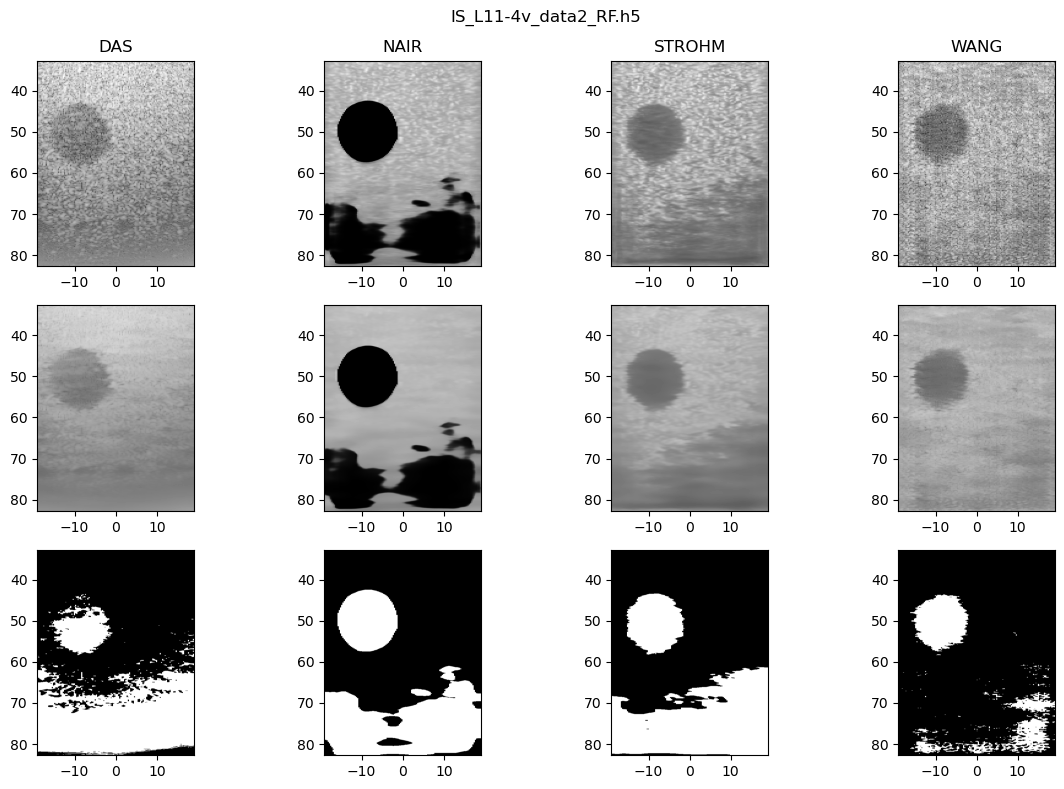

In [20]:
# ------ Plotting segmentations
nsegs = len(segmentations)
fig, ax = plt.subplots(nrows=3, ncols=nsegs, figsize=(3*nsegs, 8))
for counter, name in enumerate(segmentations):
    ax[0, counter].set_title(name)
    ax[0, counter].imshow(bmodes[name], cmap="gray", vmin=-60, vmax=0, **opts)
    ax[1, counter].imshow(nls[name], cmap="gray", vmin=0, vmax=1, **opts)
    ax[2, counter].imshow(segmentations[name], cmap="gray", vmin=0, vmax=1, **opts)
plt.suptitle('%s' % h5name)
plt.tight_layout()

In [21]:
iou_list = {}
for counter, name in enumerate(segmentations):
    roi_comp= segmentations[name]
    iou_list[name] = calculate_iou(roi_ref, roi_comp)
iou_list

{'DAS': 0.1362565164607584,
 'NAIR': 0.22656659584448552,
 'STROHM': 0.2041158963140088,
 'WANG': 0.4612021144684461}

In [25]:
bmodes.keys()

dict_keys(['DAS', 'NAIR', 'STROHM', 'WANG'])

In [37]:
#  img - input image
#  t - search window
#  f - similarity window
#  h - degree of filtering

-60.0

In [53]:
bmodes.keys()

dict_keys(['DAS', 'NAIR', 'STROHM', 'WANG'])

In [125]:
img = (bmodes['WANG']+60)/60
img = resize(img,(128,128))              # Reduce the test runtime

img_noisy = img
# img_noisy = util.random_noise(img, mode='speckle')

# OBNLM Denoising
sigma = 0.2
img_denoised = obnlm(img_noisy, 15, 3, sigma)

Text(0.5, 1.0, 'Segmentation')

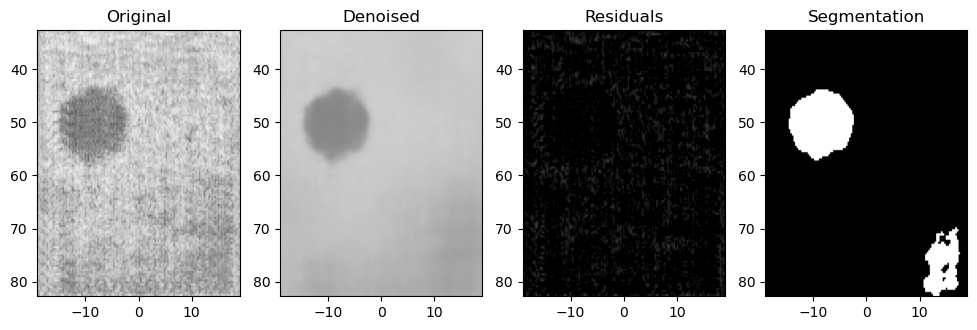

In [126]:
# Show results
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(3*4, 8))

ax[0].imshow(img, cmap=cm.Greys_r, vmin=0, vmax=1, **opts)
ax[1].imshow(img_denoised, cmap=cm.Greys_r, vmin=0, vmax=1, **opts)
ax[2].imshow(img_noisy-img_denoised, cmap=cm.Greys_r, vmin=0, vmax=1, **opts)
ax[3].imshow(img_denoised<0.55, cmap=cm.Greys_r, vmin=0, vmax=1, **opts)
ax[0].set_title('Original')
ax[1].set_title('Denoised')
ax[2].set_title('Residuals')
ax[3].set_title('Segmentation')

In [79]:
ms_ssim_list = {}
msssim_ref = torch.from_numpy((roi_ref[None, None, :]*1.0).astype('float32'))
    
for counter, name in enumerate(segmentations):
    roi_comp= segmentations[name]
    msssim_comp = torch.from_numpy((roi_comp[None, None, :]*1.0).astype('float32'))
    ms_ssim_list[name] = ms_ssim(msssim_ref, msssim_comp).item()
    # print(ms_ssim(msssim_ref, msssim_comp).item())
ms_ssim_list

{'DAS': 0.6995134353637695,
 'NAIR': 0.7078443765640259,
 'STROHM': 0.7760232090950012,
 'WANG': 0.7308696508407593}

In [69]:
"""
Python Code for the Non local filter (Speckle)
proposed for P. Coupe, P. Hellier, C. Kervrann and C. Barillot in
"Nonlocal Means-Based Speckle Filtering for
Ultrasound Images"

For Image Processing Denoising Project
"""

# Matplotlib library
import matplotlib.pyplot as plt
from matplotlib import cm

# Numpy library
import numpy as np

from skimage import util

from skimage import data
from skimage import img_as_float
from skimage.transform import resize

#  img - input image
#  t - search window
#  f - similarity window
#  h - degree of filtering

def obnlm(img,t,f,h):             # 
    img = img_as_float(img)
    [m, n]  = img.shape
    img_denoised = np.zeros((m,n))
    h = h*h

    # Normalization
    kernel=np.zeros((2*f+1,2*f+1))   
    for d in range(1,f+1) :
        value = 1. / ((2*d+1) * (2*d+1))
        for i in range (-d,d+1) :
            for j in range (-d,d+1) :
                kernel[f-i,f-j] = kernel[f-i,f-j] + value 

    kernel = kernel / f
    kernel = kernel / sum(sum(kernel))
    vkernel = np.reshape(kernel, (2*f+1)*(2*f+1) )


    pdimg = np.pad(img, ((f,f)) , mode='symmetric')     # padding

    # Denoising
    for i in range(0,m) :
        for j in range(0,n) :
            i1 = i + f
            j1 = j + f
                
            W1 = pdimg[range(i1-f,i1+f+1),:]
            W1 = W1[:,range(j1-f,j1+f+1)]
                         
            wmax = 0 
            average = 0
            sweight = 0
         
            rmin = max(i1-t,f)
            rmax = min(i1+t,m+f-1)
            smin = max(j1-t,f)
            smax = min(j1+t,n+f-1)
         
            # Find similarity between neighborhoods W1(center) and W2(surrounding)
            for r in range(rmin,rmax+1) :
                for s in range(smin,smax+1) :
                    if ((r==i1) and (s==j1)) :
                        continue
                    W2 = pdimg[range(r-f,r+f+1),:]
                    W2 = W2[:,range(s-f,s+f+1)]
                    # Use Pearson Distance
                    temp = np.reshape(((np.square(W1-W2))/W2), (2*f+1)*(2*f+1))
                    d = np.dot(vkernel,temp)
                    w =  np.exp(-d/h)                 
                    if (w>wmax) :
                        wmax=w
                
                    sweight = sweight + w
                    average = average + w*pdimg[r,s]
             
            average = average + wmax*pdimg[i1,j1]
            sweight = sweight + wmax               # Calculation of the weight
                   
            # Compute value of the denoised pixel 
            if (sweight > 0) :
                img_denoised[i,j] = average / sweight
            else :
                img_denoised[i,j] = img[i,j]
                
    return img_denoised  

In [ ]:
############    OBNL     ###################
sigma = 0.2  # for data2 frame 65
obnls = {}
segmentations = {}
for counter, name in enumerate(bmodes):
    print(f"{counter} - {name}")
    bmode = bmodes[name]
    bmode_img = (bmode + 60) / 60
    bmode_img = resize(bmode_img,(100,80))              # Reduce the test runtime
    
    # OBNLM Denoising
    bmode_obnl = obnlm(bmode_img, 5, 3, sigma)
    # bmode_obnl = obnlm(bmode_img, 15, 3, sigma)
    
    obnls[name] = bmode_obnl
################################